In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import torch
from torchtext.vocab import vocab
from torch.utils.data import Dataset
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/imanrahgozarabadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/imanrahgozarabadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Downloading and Exploring the Data:

The data used in this project is the women's clothing product reviews available to the public from the following S3 bucket:
`s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv` 
Let's download the data.
Note: This requires the AWS SDK to be installed and configured on the local machine if running locally. 

In [3]:
if 'data' not in os.listdir("./.."):
    os.mkdir("./../data")

if 'raw_data' not in os.listdir("./../data"):
    os.mkdir("./../data/raw_data")

if "womens_clothing_ecommerce_reviews.csv" not in os.listdir("./../data/raw_data"):
    !aws s3 cp s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv ./data/raw_data

Now, let's explore the data and gain some information about it.

In [4]:
data = pd.read_csv("./../data/raw_data/womens_clothing_ecommerce_reviews.csv")
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [6]:
data.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


We will be using the `Review Text`  Column to generate the inputs for sentiment analysis and the `Rating` column to find the sentiment of eah review. 
Additionally, the `Class Name` column will be used to balance the dataset.
As a result, we only keep these columns for further analysis.

Also, since the names of these colmns are not easy to use prorammatically, the columns will be renamed to more proper names.
Products with lower than 10 reviews will also be removed as they don't have enough reviews to be inclluded

In [7]:
data_transformed =  data[["Review Text", "Rating", "Class Name"]].copy()
data_transformed.rename(columns = {"Review Text":'review', "Rating":"rating", "Class Name":"product_category"}, inplace = True)
data_transformed.dropna(inplace = True)

In [8]:
data_transformed.groupby("product_category").size()

product_category
Blouses           2983
Casual bottoms       1
Chemises             1
Dresses           6145
Fine gauge        1059
Intimates          147
Jackets            683
Jeans             1104
Knits             4626
Layering           132
Legwear            158
Lounge             669
Outerwear          319
Pants             1350
Shorts             304
Skirts             903
Sleep              214
Sweaters          1380
Swim               332
Trend              118
dtype: int64

Obviously, there is a significant imbalance between the number of reviews for different product categories, let' remove products that have less than 10 reviews to make the dataset a bit more balanced. 

In [9]:
data_transformed  = data_transformed.groupby("product_category").filter(lambda review: len(review) > 10)

We would like to use the data to train a sentiminet analyzer, the rating column could be used to assign a sentiment to each review.The following policy is used to assign a sentiment to each review:
- 1 <= rating <= 3 ==> Negative with a class value of 0 
- 3 < rating ==> Positive with a class value of 1

In [10]:
def rating_to_sentiment(rating):
    if rating in {1, 2, 3}:
        return 0
    else:
        return 1

data_transformed["sentiment"] = data_transformed["rating"].apply(lambda rating: rating_to_sentiment(rating))
data_transformed.drop(columns = "rating", inplace = True)

In [11]:
data_transformed.to_csv("./../data/raw_data/womens_clothing_ecommerce_reviews_transformed.csv", index = False)
data_transformed.head()


,review,product_category,sentiment
0,If this product was in petite i would get the...,Blouses,1
1,Love this dress! it's sooo pretty. i happene...,Dresses,1
2,I had such high hopes for this dress and reall...,Dresses,0
3,I love love love this jumpsuit. it's fun fl...,Pants,1
4,This shirt is very flattering to all due to th...,Blouses,1


# Balancing the Dataset

In [12]:
data_transformed = pd.read_csv("./../data/raw_data/womens_clothing_ecommerce_reviews_transformed.csv")

Since this is a classifier, the dataset should not be biased. The bias we are interested in could present itself in two ways:
- Number of reviews for each sentiment : We want the classifier to see the same number of reviews with different sentiments, if the model is trained on a dataset with more positive sentiments, then it might be overfitted to positive reviews and might not work well for neutral and negative reviews.
- Number of reviews for each product category : The balance in the number of reviews for each product category is also important. Product category has a significant impact on which words the classifier sees more and associates to the sentiments.

Let's have a look at how balanced the dataset is now.

Text(0.5, 1.0, 'Number of Reviews by Sentiment')

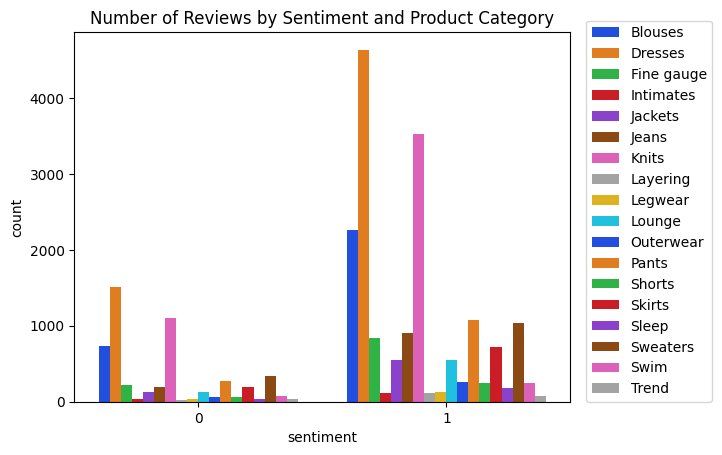

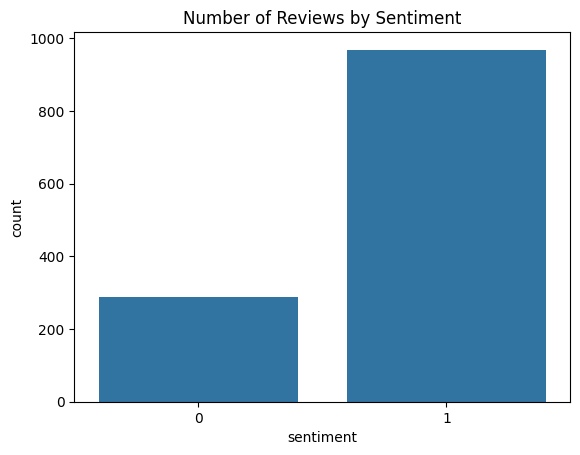

In [13]:
data_transformed_grouped = data_transformed.groupby(["sentiment", "product_category"], as_index=False).size()
data_transformed_grouped.rename(columns = {"size":"count"}, inplace=True)
# Plotting the number of reviews for each setiment and idfferent product categories
sns.barplot(x = data_transformed_grouped["sentiment"], y = data_transformed_grouped["count"],\
        hue = data_transformed_grouped["product_category"], palette = 'bright')
plt.legend(bbox_to_anchor=(1.3, 1.05), loc='upper right')
plt.title("Number of Reviews by Sentiment and Product Category")
# Plotting the number of reviews for each setiment and idfferent product categories
plt.figure()
sns.barplot(x = data_transformed_grouped["sentiment"], y = data_transformed_grouped["count"], errorbar = None)
plt.title("Number of Reviews by Sentiment")

In order to make the dataset more balanced for both product category and seniment:

In [14]:
data_transformed_grouped_for_balance = data_transformed.groupby(["sentiment", "product_category"])[["review","sentiment", "product_category"]]
data_transformed_balanced_both = data_transformed_grouped_for_balance.apply(lambda x: \
                                x.sample(data_transformed.groupby(["sentiment", "product_category"]).size().min()))\
                                .reset_index(drop = True)
data_transformed_balanced_both

,review,sentiment,product_category
0,I wanted to love this top to go with a pair of...,0,Blouses
1,I try to find something to like about everythi...,0,Blouses
2,The top is a pretty and has a nice pattern. it...,0,Blouses
3,This is a sweet top as it is shown. on the mod...,0,Blouses
4,Bought this in the white. i found it to run na...,0,Blouses
...,...,...,...
679,I tried on a size 8 in the store just for fun....,1,Trend
680,Flattering fitted form. flowing fabric. well m...,1,Trend
681,I was very hesitant about this. i read the pre...,1,Trend
682,I love his cardigan! i knew the small would be...,1,Trend


Now let's see if the dataset is balanced:

The total number of reviews in the balanced dataset:684


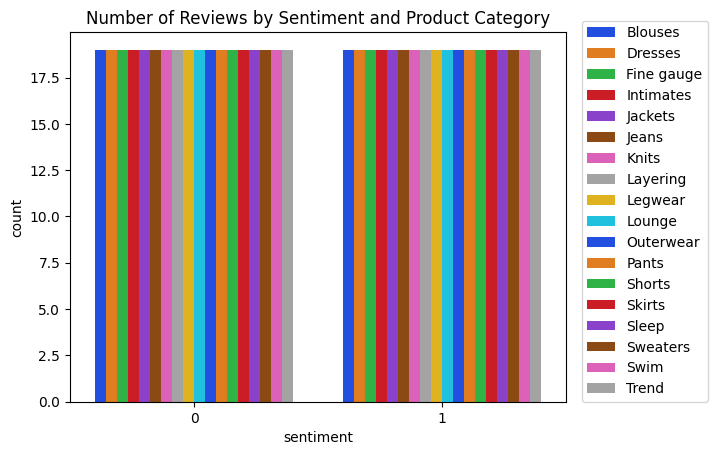

In [15]:
data_transformed_balanced_both_grouped = data_transformed_balanced_both.groupby(["sentiment", "product_category"], as_index = False).size()
data_transformed_balanced_both_grouped.rename(columns = {"size":"count"}, inplace=True)
# Plotting the number of reviews for each setiment and idfferent product categories
sns.barplot(x = data_transformed_balanced_both_grouped["sentiment"], y = data_transformed_balanced_both_grouped["count"],\
        hue = data_transformed_balanced_both_grouped["product_category"], palette = 'bright')
plt.legend(bbox_to_anchor=(1.3, 1.05), loc='upper right')
plt.title("Number of Reviews by Sentiment and Product Category")
print(f"The total number of reviews in the balanced dataset:{data_transformed_balanced_both.shape[0]}")

The datset is now balanced, but we have lost almost all of our data. Since we care about the size of our dataset more than the class balance of product categories we will not balance the dataset based on the product category and will only be balancing the dataset based on the sentiments.

In [16]:
data_transformed_grouped_for_balance = data_transformed.groupby(["sentiment"])[["review","sentiment", "product_category"]]
data_transformed_balanced = data_transformed_grouped_for_balance.apply(lambda x: \
                                x.sample(data_transformed.groupby(["sentiment"]).size().min()))\
                                .reset_index(drop = True)
data_transformed_balanced

,review,sentiment,product_category
0,The tops looks fitted on the model because she...,0,Blouses
1,This shirt is beautiful however i thought tha...,0,Fine gauge
2,Pants are overpriced and very uncomfortable. t...,0,Pants
3,I love these pants -- bought them in the musta...,0,Pants
4,This is a very soft and comfortable jacket but...,0,Lounge
...,...,...,...
10381,It is so beautiful and just as shown in the pi...,1,Intimates
10382,I did not find this blouse to be tight in the ...,1,Blouses
10383,"I am 5'8"" and about 145 lbs - curvy through hi...",1,Knits
10384,Although i was worried it wouldn't live up to ...,1,Knits


The total number of reviews in the balanced dataset:10386


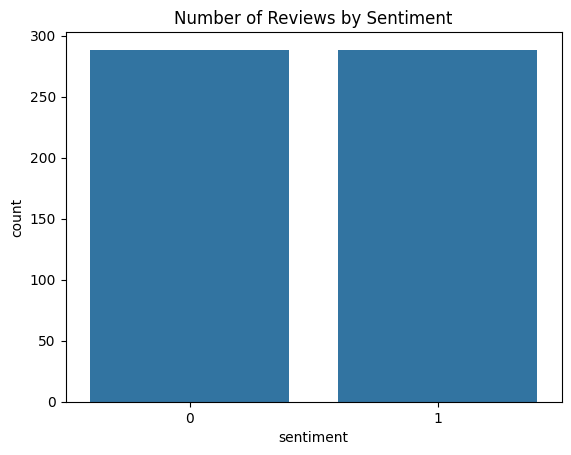

In [17]:
data_transformed_balanced_grouped = data_transformed_balanced.groupby(["sentiment", "product_category"], as_index = False).size()
data_transformed_balanced_grouped.rename(columns = {"size":"count"}, inplace=True)

# Plotting the number of reviews for each setiment and idfferent product categories
plt.figure()
sns.barplot(x = data_transformed_balanced_grouped["sentiment"], y = data_transformed_balanced_grouped["count"], errorbar = None)
plt.title("Number of Reviews by Sentiment")

print(f"The total number of reviews in the balanced dataset:{data_transformed_balanced.shape[0]}")

The dataset is balanced now and we have enough data to train our model. So we save the data and move on to the next step which is the preparation of the data for our NLP task.
But before we move on to the next stage, let's divide the dataset into training, validation and test sets. 

In [18]:
data_transformed_balanced.to_csv("./../data/raw_data/womens_clothing_ecommerce_reviews_balanced.csv", index = False)

if "training" not in os.listdir("./../data"):
    os.mkdir("./../data/training")

if "validation" not in os.listdir("./../data"):
    os.mkdir("./../data/validation")

if "test" not in os.listdir("./../data"):
    os.mkdir("./../data/test")

training_data, temp_data = train_test_split(data_transformed_balanced, test_size = 0.2, random_state = 5)
validation_data, test_data = train_test_split(temp_data, test_size = 0.33, random_state = 5)

training_data.to_csv("./../data/training/womens_clothing_ecommerce_reviews_balanced_training.csv", index = False)
validation_data.to_csv("./../data/validation/womens_clothing_ecommerce_reviews_balanced_validation", index = False)
test_data.to_csv("./../data/test/womens_clothing_ecommerce_reviews_balanced_test", index = False)


# Preprocessing the Data for NLP Task

In [20]:
training_data = pd.read_csv("./../data/training/womens_clothing_ecommerce_reviews_balanced_training.csv")
validation_data = pd.read_csv("./../data/validation/womens_clothing_ecommerce_reviews_balanced_validation")
test_data = pd.read_csv("./../data/test/womens_clothing_ecommerce_reviews_balanced_test")

As is required in any NLP task, we start with creating a vocabiulary from the training and validation sets. To do this let's first read all of the review texts from the training data and save it as a text corpus.

In [21]:
# Creating a text corpus from the training and validation data
corpus_data = pd.concat([training_data["review"], validation_data["review"]], axis = 0)
corpus = '\n'.join(training_data["review"].values)

with open("./../data/corpus.txt", "w") as file:
    file.write(corpus)

print(corpus[0:300])

I have this top with the red stitching and it is one of my most favorite items from retailer ever. i wear it with a tank top underneath so i haven't noticed any itchiness like the other reviewer mentioned.   i wear it with slightly cropped slim boyfriend jeans and i get so many compliments every tim


Now we tookenize the corpus to extract meaningful language tokens (mostly words) and create a vocabulary. We also need to process the resulting tokens as well. For intance, we will be removing characters that do not add to the sentiment of the text or tokens that are not repeated enough in the corpus. This helps us keep the number of words in our vocabulary down. 

In [22]:
def cleanup_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z.?!:)( \n]+", "", text)
    text = re.sub(r"\.{2,}", ".", text)
    text = re.sub(r"\.{2,}", "!", text)
    text = re.sub(r"\.{2,}", "?", text)
    text = re.sub(r"\.{2,}", ")", text)
    text = re.sub(r"\.{2,}", "(", text)
    text = re.sub(r"\.{2,}", ":", text)
    return text

def create_vocab(text, tokenizer, lemmatizer, unk_token, pad_token):
    tokenized_text = tokenizer(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    token_freqs = Counter(lemmatized_text)
    vocabulary = vocab(token_freqs, min_freq = 10, specials = [pad_token, unk_token])
    vocabulary.set_default_index(1)
    return vocabulary

def process_reviews(review, tokenizer, lemmatizer, vocabulary, max_len):
    review_cleaned = cleanup_text(review)
    review_tokenized = tokenizer(review_cleaned)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in review_tokenized]
    review_processed = vocabulary(lemmatized_text)
    if len(review_processed) < max_len:
        review_processed.extend([0] * (max_len - len(review_processed)))
    elif len(review_processed) > max_len:
        review_processed = review_processed[:max_len]
    return review_processed
    

In [23]:
corpus_cleaned = cleanup_text(corpus)
vocabulary = create_vocab(corpus_cleaned, word_tokenize, WordNetLemmatizer(), "<unk>", "<pad>")
torch.save(vocabulary, './../data/vocabulary.pth')


training_data["review_processed"] = training_data["review"].apply(lambda x: process_reviews(x, word_tokenize, WordNetLemmatizer(), vocabulary, 500))
validation_data["review_processed"] = validation_data["review"].apply(lambda x: process_reviews(x, word_tokenize, WordNetLemmatizer(), vocabulary, 500))
test_data["review_processed"] = test_data["review"].apply(lambda x: process_reviews(x, word_tokenize, WordNetLemmatizer(), vocabulary, 500))

training_data_processed = training_data[["review_processed", "sentiment"]]
validation_data_processed  = validation_data[["review_processed", "sentiment"]]
test_data_processed  = test_data[["review_processed", "sentiment"]]

training_data_processed.to_csv("./../data/training/training_data_processed.csv", index = False)
validation_data_processed.to_csv("./../data/validation/validation_data_processed.csv", index = False)
test_data_processed.to_csv("./../data/test/test_data_processed.csv", index = False)


In [24]:
def convert_to_tensor(dataframe):
        review_processed_values = dataframe['review_processed'].tolist()
        sentiment_values = dataframe['sentiment'].tolist()

        review_processed_tensor = torch.tensor(review_processed_values)
        sentiment_tensor = torch.tensor(sentiment_values)

        sentiment_tensor = sentiment_tensor.unsqueeze(1)
        combined_tensor = torch.cat((review_processed_tensor, sentiment_tensor), dim=1)
        return combined_tensor

training_data_tensor = convert_to_tensor(training_data_processed)
validation_data_tensor = convert_to_tensor(validation_data_processed)
test_data_tensor = convert_to_tensor(test_data_processed)



In [25]:
class dataset(Dataset):
    def __init__(self,data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

train_dataset = dataset(training_data_tensor)
validaton_dataset = dataset(validation_data_tensor)
test_dataset = dataset(test_data_tensor)

torch.save(train_dataset, "./../data/training/training_dataset.pth")
torch.save(validaton_dataset, "./../data/validation/validation_dataset.pth")
torch.save(test_dataset, "./../data/test/test_dataset.pth")